In [1]:
import cv2
import numpy as np
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,GlobalMaxPooling2D
from keras.layers import Input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras import optimizers
from keras.engine.topology import get_source_inputs
import h5py
import utils,params

class ImgGenerator():
    def __init__(self,img_path,batch_id,batch_size,input_shape=(720,1280,3)):
        self.img_path = img_path
        self.batch_id = batch_id
        self.batch_size = batch_size
        self.current_frame = 0
        self.input_shape = input_shape
        
    def next_batch(self):
        #标注处理
        label = utils.get_human_steering(self.batch_id)[self.current_frame:self.current_frame+self.batch_size]
        label = np.array(label)
        labels = []
        for i in range(len(label)):
            labels.append([label[i]])
        lables = np.array(labels)
        #图像处理        
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv'.format(self.batch_id))
        cap = cv2.VideoCapture(vid_path)
        nframe = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) - 2)
        if( (self.current_frame+self.batch_size) > nframe):
            self.batch_size = nframe - self.current_frame
        images = []
        #images = np.zeros((self.batch_size,params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c),dtype=np.float)
        for i in range(self.current_frame,self.current_frame+self.batch_size):
            utils.cv2_goto_frame(cap,i) 
            ret, frame = cap.read()
            if (ret == True):
                shape = frame.shape
                frame = frame[int(shape[0]/3):shape[0]-150, 0:shape[1]]
                frame = cv2.resize(frame, (params.FLAGS.img_w, params.FLAGS.img_h), interpolation=cv2.INTER_AREA)
                frame = np.resize(frame, (params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c))
                #images[i-self.current_frame]=frame
                images.append(frame)
                #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                #cv2.imshow('frame',gray)
                del frame
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        images = np.array(images)    
        self.current_frame = utils.cv2_current_frame(cap)
        cap.release()
        cv2.destroyAllWindows()

        return (images[:int(self.batch_size*0.8)],labels[:int(self.batch_size*0.8)],
                images[int(self.batch_size*0.8):],labels[int(self.batch_size*0.8):])

Using TensorFlow backend.


In [2]:
from  keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers import Lambda
def VGG16_REGRESSION(input_shape):
    base_model = VGG16(include_top=False, weights='imagenet',input_shape=input_shape)
    inputs = Input(shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c))

    for layer in base_model.layers:
        layer.trainable = False
    
    #x = Lambda(lambda x:preprocess_input(x))(inputs)

    x = base_model(inputs)
    x = Flatten(name='flatten')(x)
    x = Dense(100, activation='relu', name='fc1')(x)
    x = Dense(50, activation='relu', name='fc2')(x)
    x = Dense(10, activation='relu', name='fc3')(x)
    x = Dense(1, name='predictions')(x)
    
    model = Model(inputs,x)
    return model

In [ ]:
img_path = params.data_dir

batch_size = 256
input_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)
model = VGG16_REGRESSION(input_shape=input_shape)
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',
               optimizer=sgd)

model.summary()
for epochid in ['02']:
    imggen = ImgGenerator(img_path=img_path,
                     batch_id=epochid,
                     batch_size=batch_size,
                     input_shape=input_shape)
    while True:
        x_train,y_train,x_valid,y_valid = imggen.next_batch()
      
        if(len(x_train) == 0):
            break
        model.fit(x_train, y_train,epochs=5,batch_size=32,validation_data=(x_valid, y_valid),shuffle=False)
    
utils.save_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 100)               204900    
_________________________________________________________________
fc2 (Dense)                  (None, 50)                5050      
_________________________________________________________________
fc3 (Dense)                  (None, 10)                510       
_________________________________________________________________
predictions (Dense)          (None, 1)                 11        
Total para

In [2]:
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print(x_train.shape)
'''
input_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)
model = VGG16_REGRESSION(input_shape=input_shape)
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',
               optimizer=sgd)
model.fit(x_train, y_train,epochs=5,batch_size=32,validation_data=(x_test, y_test),shuffle=True)
'''

(50000, 32, 32, 3)


"\ninput_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)\nmodel = VGG16_REGRESSION(input_shape=input_shape)\nsgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)\nmodel.compile(loss='mean_squared_error',\n               optimizer=sgd)\nmodel.fit(x_train, y_train,epochs=5,batch_size=32,validation_data=(x_test, y_test),shuffle=True)\n"

Model already exists, do you want to reuse? (y/n): y


NameError: name 'preprocess_input' is not defined

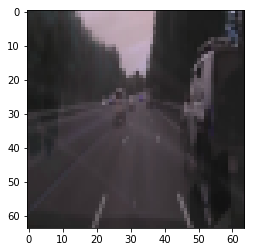

In [5]:
from matplotlib import pyplot as plot
%matplotlib inline
from sklearn.metrics import r2_score

img_path = params.data_dir
input_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)
x_test,y_test,_,_ = ImgGenerator(img_path,'02',batch_size=256,input_shape=input_shape).next_batch()


for i in range(len(x_test)):
    plot.imshow(x_test[i])
    #print(x_test[i:i+1].cumsum())

model = utils.get_model()
y_predict = model.predict(x_test)
score = r2_score(y_test,y_predict)
print('Score:',score)